In [1]:
#import necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from time import time
import re
from numpy.random import normal
from scipy.stats import kurtosis, skew
import math
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import roc_curve, auc, plot_confusion_matrix, mean_squared_error, mean_absolute_error, classification_report, precision_score, recall_score, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from six import StringIO 
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from IPython.display import Image
import pydotplus
import warnings
warnings.filterwarnings('ignore')

flights = pd.read_csv('final_data.csv', index_col=0)

In [2]:
flights.head()

,SCHEDULED_DEPARTURE,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_DELAY,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,...,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12,DELAYED
0,1340,56,128,1436,-13,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1910,155,867,2145,-12,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,630,110,672,820,-8,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
3,810,100,546,950,152,0,0,0,152,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,1000,498,3904,1318,-2,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1


### Functions Used for Project

In [52]:
#write function to train and predict model, then print score results 

def model_fit(smotex, smotey, trainx, trainy, testx, testy, model, name):  
    
    model.fit(smotex, smotey)

    test_prediction = model.predict(testx)
    train_prediction = model.predict(trainx)
    
    result = {'model': name}
    
    result['train_accuracy'] = np.around((accuracy_score(trainy, train_prediction)), decimals=3)
    result['train_precision'] = np.around((precision_score(trainy, train_prediction)), decimals=3)
    result['train_recall'] = np.around((recall_score(trainy, train_prediction)), decimals=3)
    result['train_f1'] = np.around((f1_score(trainy, train_prediction)), decimals=3)
    
    result['test_accuracy'] = np.around((accuracy_score(testy, test_prediction)), decimals=3)
    result['test_precision'] = np.around((precision_score(testy, test_prediction)), decimals=3)
    result['test_recall'] = np.around((recall_score(testy, test_prediction)), decimals=3)
    result['test_f1'] = np.around((f1_score(testy, test_prediction)), decimals=3)
    
    print("\n")
    
    print("Train Score Results")
    print(classification_report(trainy, train_prediction))       
    print("Train Set Accuracy:", result['train_accuracy'])
    print("Train Set Precision:", result['train_precision'])
    print("Train Set Recall:", result['train_recall'])
    print("Train Set F1-Score:", result['train_f1'])

    print("\n")
    
    print("Test Score Results")    
    print(classification_report(testy, test_prediction)) 
                                      
    print("Test Set Accuracy:", result['test_accuracy'])  
    print("Test Set Precision:", result['test_precision']) 
    print("Test Set Recall:", result['test_recall'])
    print("Test Set F1-Score:", result['test_f1'])
                                      
    
    print("\n")
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
    trainmatrix = plot_confusion_matrix(model, trainx, trainy, cmap=plt.cm.Blues, ax=ax1)
    testmatrix = plot_confusion_matrix(model, testx, testy, cmap=plt.cm.Blues, ax=ax2)
    ax1.set_title('Train Confusion Matrix')
    ax2.set_title('Test Confusion Matrix')
    plt.tight_layout()
    plt.show()
    
    return result

In [3]:
#Create graph that shows the feature importances per tree 
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

In [4]:
# function for plotting a feature importance histogram (very similar to function above - may not need both)
def features_plot(df, title):
    df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = df, orient = 'h', color = 'blue') \
       .set_title(title, fontsize = 20)

In [5]:
#Function for creating a feature importance dataframe
def features_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

### Train Test Split

In [4]:
y = flights['DELAYED']
X = flights.drop(['DELAYED'], axis=1)

In [5]:
#Investigate the value counts of our y-variable
y.value_counts(normalize=True)

0    0.6284
1    0.3716
Name: DELAYED, dtype: float64

We see that there is quite a bit of a class imbalance in our target variable; 62.8% of our flights were not delayed while only 37.1% were delayed. As a result, we will apply a SMOTE technique in order to create synthesized data in order to improve our model. 

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [7]:
# Previous original class distribution
print('Original class distribution: \n')
print(y.value_counts())
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train) 
# Preview synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_resampled).value_counts()) 

Original class distribution: 

0    6284
1    3716
Name: DELAYED, dtype: int64
-----------------------------------------
Synthetic sample class distribution: 

1    4729
0    4729
Name: DELAYED, dtype: int64


### 1. KNN

In [11]:
#Scale the data
scaler = StandardScaler()  
scaler.fit(X_train)

#Scale original X_train and X_test
X_train_scaled = scaler.transform(X_train)  
X_test_scaled = scaler.transform(X_test)

#Scale the resampled train 
X_train_resampled_scaled = scaler.transform(X_train_resampled)  

In [12]:
#Fit and predict the vanilla model
knnmodel = KNeighborsClassifier()



Train Score Results
              precision    recall  f1-score   support

           0       0.84      0.81      0.82      4729
           1       0.69      0.73      0.71      2771

    accuracy                           0.78      7500
   macro avg       0.77      0.77      0.77      7500
weighted avg       0.78      0.78      0.78      7500

Train Set Accuracy: 0.781
Train Set Precision: 0.692
Train Set Recall: 0.735
Train Set F1-Score: 0.713


Test Score Results
              precision    recall  f1-score   support

           0       0.69      0.67      0.68      1555
           1       0.48      0.50      0.49       945

    accuracy                           0.61      2500
   macro avg       0.59      0.59      0.59      2500
weighted avg       0.61      0.61      0.61      2500

Test Set Accuracy: 0.609
Test Set Precision: 0.483
Test Set Recall: 0.501
Test Set F1-Score: 0.492




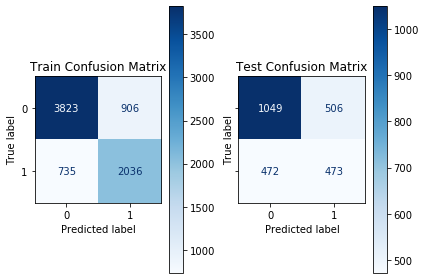

In [63]:
#Apply the model and print metrics
knnresult = model_fit(X_train_resampled_scaled, y_train_resampled, X_train_scaled, y_train, X_test_scaled, y_test, knnmodel, 'knn')

In [54]:
knnresults

{'model': 'knn',
 'train_accuracy': 0.781,
 'train_precision': 0.692,
 'train_recall': 0.735,
 'train_f1': 0.713,
 'test_accuracy': 0.609,
 'test_precision': 0.483,
 'test_recall': 0.501,
 'test_f1': 0.492}

### 2. Bayes Classification Model

In [57]:
#Instansiate the vanilla model
bayes = GaussianNB()

In [58]:
bayes.fit(X_train_resampled, y_train_resampled)

GaussianNB()



Train Score Results
              precision    recall  f1-score   support

           0       0.75      0.99      0.86      4729
           1       0.97      0.44      0.60      2771

    accuracy                           0.79      7500
   macro avg       0.86      0.72      0.73      7500
weighted avg       0.83      0.79      0.76      7500

Train Set Accuracy: 0.788
Train Set Precision: 0.973
Train Set Recall: 0.438
Train Set F1-Score: 0.604


Test Score Results
              precision    recall  f1-score   support

           0       0.74      0.99      0.85      1555
           1       0.98      0.43      0.60       945

    accuracy                           0.78      2500
   macro avg       0.86      0.71      0.72      2500
weighted avg       0.83      0.78      0.75      2500

Test Set Accuracy: 0.78
Test Set Precision: 0.976
Test Set Recall: 0.43
Test Set F1-Score: 0.597




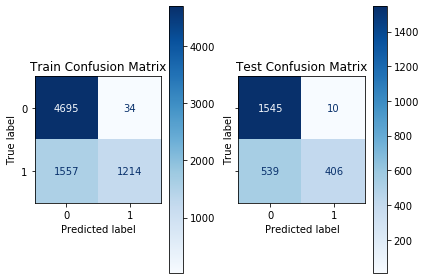

In [59]:
#Apply the modelfit function
bayesresult = model_fit(X_train_resampled, y_train_resampled, X_train, y_train, X_test, y_test, bayes, 'bayes')

### 3. Decision Tree Classifier

In [60]:
#Instansiate the vanilla model 
decisiontree = DecisionTreeClassifier(random_state=42)



Train Score Results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4729
           1       1.00      1.00      1.00      2771

    accuracy                           1.00      7500
   macro avg       1.00      1.00      1.00      7500
weighted avg       1.00      1.00      1.00      7500

Train Set Accuracy: 1.0
Train Set Precision: 1.0
Train Set Recall: 1.0
Train Set F1-Score: 1.0


Test Score Results
              precision    recall  f1-score   support

           0       0.78      0.77      0.78      1555
           1       0.63      0.65      0.64       945

    accuracy                           0.72      2500
   macro avg       0.71      0.71      0.71      2500
weighted avg       0.73      0.72      0.72      2500

Test Set Accuracy: 0.724
Test Set Precision: 0.63
Test Set Recall: 0.653
Test Set F1-Score: 0.641




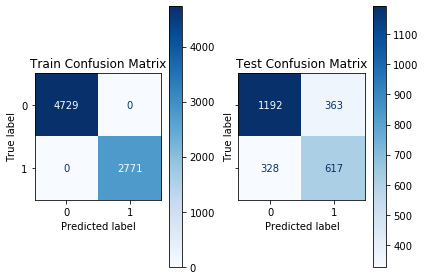

In [62]:
#Apply the model fit function 
decisiontreeresult = model_fit(X_train_resampled, y_train_resampled, X_train, y_train, X_test, y_test, decisiontree, 'decisiontree')

In [ ]:
#Code for plotting decision tree


# dot_data = StringIO()
# export_graphviz(decisiontree3, out_file=dot_data,  
#                 special_characters=True)
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# Image(graph.create_png())

### 4. Ensemble Methods

#### a. Bagging Method

In [65]:
#Instansiate the vanilla model
bagged_tree = BaggingClassifier(DecisionTreeClassifier(random_state=42), n_estimators=20)



Train Score Results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4729
           1       1.00      0.99      1.00      2771

    accuracy                           1.00      7500
   macro avg       1.00      1.00      1.00      7500
weighted avg       1.00      1.00      1.00      7500

Train Set Accuracy: 0.997
Train Set Precision: 0.999
Train Set Recall: 0.992
Train Set F1-Score: 0.996


Test Score Results
              precision    recall  f1-score   support

           0       0.80      0.89      0.84      1555
           1       0.78      0.64      0.70       945

    accuracy                           0.79      2500
   macro avg       0.79      0.76      0.77      2500
weighted avg       0.79      0.79      0.79      2500

Test Set Accuracy: 0.794
Test Set Precision: 0.776
Test Set Recall: 0.639
Test Set F1-Score: 0.701




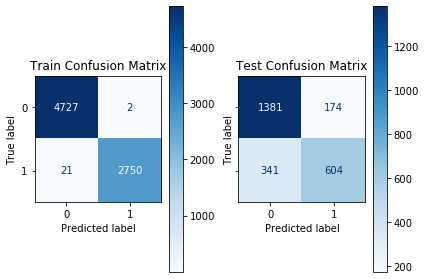

In [66]:
#Apply the model prediction
baggingresult = model_fit(X_train_resampled, y_train_resampled, X_train, y_train, X_test, y_test, bagged_tree, 'bagging')

#### b. Random Forest

In [67]:
#Instansiate the vanilla model 
randomforest = RandomForestClassifier(random_state=42)



Train Score Results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4729
           1       1.00      1.00      1.00      2771

    accuracy                           1.00      7500
   macro avg       1.00      1.00      1.00      7500
weighted avg       1.00      1.00      1.00      7500

Train Set Accuracy: 1.0
Train Set Precision: 1.0
Train Set Recall: 1.0
Train Set F1-Score: 1.0


Test Score Results
              precision    recall  f1-score   support

           0       0.81      0.91      0.86      1555
           1       0.81      0.64      0.72       945

    accuracy                           0.81      2500
   macro avg       0.81      0.78      0.79      2500
weighted avg       0.81      0.81      0.80      2500

Test Set Accuracy: 0.809
Test Set Precision: 0.811
Test Set Recall: 0.644
Test Set F1-Score: 0.718




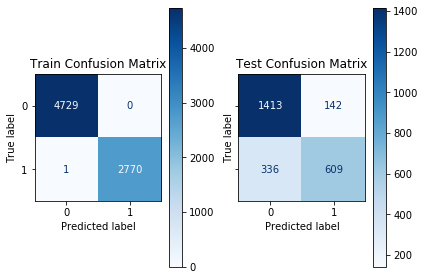

In [68]:
randomforestresult = model_fit(X_train_resampled, y_train_resampled, X_train, y_train, X_test, y_test, randomforest, 'randomforest')

In [26]:
#Look at another performance measure: mean 3-Fold cross validation score 
mean_rf_cv_score = np.mean(cross_val_score(randomforest, X_train, y_train, cv=3))
mean_rf_cv_score

0.8092

### 5. Boosting

#### a. Adaboost

In [69]:
#Instansiate the vanilla model
adb = AdaBoostClassifier(random_state=42)



Train Score Results
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      4729
           1       0.78      0.69      0.73      2771

    accuracy                           0.81      7500
   macro avg       0.81      0.79      0.80      7500
weighted avg       0.81      0.81      0.81      7500

Train Set Accuracy: 0.815
Train Set Precision: 0.781
Train Set Recall: 0.693
Train Set F1-Score: 0.734


Test Score Results
              precision    recall  f1-score   support

           0       0.82      0.87      0.84      1555
           1       0.76      0.68      0.72       945

    accuracy                           0.80      2500
   macro avg       0.79      0.77      0.78      2500
weighted avg       0.80      0.80      0.79      2500

Test Set Accuracy: 0.798
Test Set Precision: 0.762
Test Set Recall: 0.676
Test Set F1-Score: 0.716




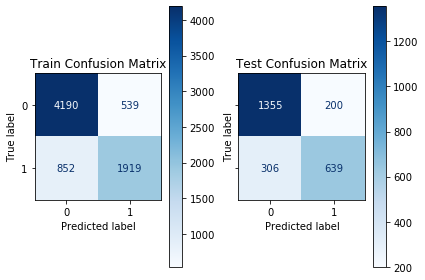

In [70]:
#Fit and predict model and show results
adbresult = model_fit(X_train_resampled, y_train_resampled, X_train, y_train, X_test, y_test, adb, 'Adaboost')

In [29]:
#Look at another performance measure: mean 3-Fold cross validation score 
adb_mean_cv = cross_val_score(adb, X, y, cv=3).mean()

print(f"Mean Adaboost Cross-Val Score (k=3): {adb_mean_cv: .2%}")

Mean Adaboost Cross-Val Score (k=3):  81.31%


#### b. Gradient Boosting

In [71]:
#Instansiate the vanilla model
gb = GradientBoostingClassifier(random_state=42)



Train Score Results
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      4729
           1       0.82      0.70      0.75      2771

    accuracy                           0.83      7500
   macro avg       0.83      0.80      0.81      7500
weighted avg       0.83      0.83      0.83      7500

Train Set Accuracy: 0.833
Train Set Precision: 0.823
Train Set Recall: 0.696
Train Set F1-Score: 0.755


Test Score Results
              precision    recall  f1-score   support

           0       0.82      0.89      0.85      1555
           1       0.79      0.68      0.73       945

    accuracy                           0.81      2500
   macro avg       0.80      0.78      0.79      2500
weighted avg       0.81      0.81      0.81      2500

Test Set Accuracy: 0.81
Test Set Precision: 0.789
Test Set Recall: 0.678
Test Set F1-Score: 0.73




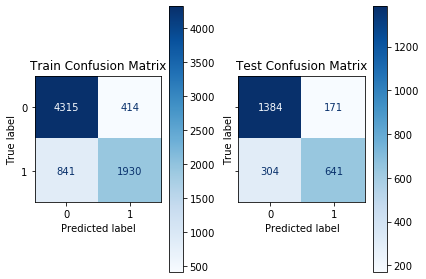

In [72]:
#Fit and predict model and show results
gbresult = model_fit(X_train_resampled, y_train_resampled, X_train, y_train, X_test, y_test, gb, 'Gradient_Boosting')

In [32]:
#Look at another performance measure: mean 3-Fold cross validation score 
gb_mean_cv = cross_val_score(gb, X, y, cv=3).mean()

print(f"Mean Adaboost Cross-Val Score (k=3): {gb_mean_cv: .2%}")

Mean Adaboost Cross-Val Score (k=3):  81.68%


#### c. XGBoost

In [73]:
#Instansiate the vanilla model
xgb = XGBClassifier()



Train Score Results
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      4729
           1       0.83      0.69      0.75      2771

    accuracy                           0.83      7500
   macro avg       0.83      0.80      0.81      7500
weighted avg       0.83      0.83      0.83      7500

Train Set Accuracy: 0.832
Train Set Precision: 0.827
Train Set Recall: 0.688
Train Set F1-Score: 0.751


Test Score Results
              precision    recall  f1-score   support

           0       0.82      0.89      0.85      1555
           1       0.79      0.67      0.73       945

    accuracy                           0.81      2500
   macro avg       0.80      0.78      0.79      2500
weighted avg       0.81      0.81      0.80      2500

Test Set Accuracy: 0.808
Test Set Precision: 0.79
Test Set Recall: 0.67
Test Set F1-Score: 0.725




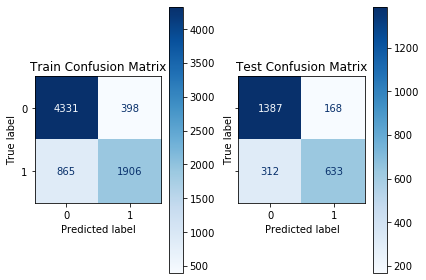

In [78]:
#Fit and predict model and show results
xgbresult = model_fit(X_train_resampled, y_train_resampled, X_train, y_train, X_test, y_test, xgb, 'XGBoost')

### 6. Support Vector Machines

In [30]:
#Add scale - scale resampled and scale the x-train like i did fo rknn

In [75]:
#Instansiate the vanilla model
svclassifier = SVC()



Train Score Results
              precision    recall  f1-score   support

           0       0.77      0.82      0.80      4729
           1       0.66      0.59      0.62      2771

    accuracy                           0.73      7500
   macro avg       0.72      0.70      0.71      7500
weighted avg       0.73      0.73      0.73      7500

Train Set Accuracy: 0.735
Train Set Precision: 0.659
Train Set Recall: 0.586
Train Set F1-Score: 0.62


Test Score Results
              precision    recall  f1-score   support

           0       0.76      0.81      0.79      1555
           1       0.65      0.59      0.62       945

    accuracy                           0.72      2500
   macro avg       0.71      0.70      0.70      2500
weighted avg       0.72      0.72      0.72      2500

Test Set Accuracy: 0.725
Test Set Precision: 0.651
Test Set Recall: 0.586
Test Set F1-Score: 0.617




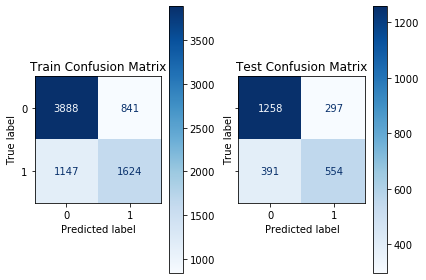

In [76]:
#Fit and predict model and show results
svmresult = model_fit(X_train_resampled, y_train_resampled, X_train, y_train, X_test, y_test, svclassifier, 'SVM')

### All Vanilla Results

In [79]:
result_list = [knnresult, bayesresult, decisiontreeresult, baggingresult, 
                randomforestresult, adbresult, xgbresult, svmresult]

In [80]:
df_results = pd.DataFrame.from_dict(result_list, orient='columns')
df_results = df_results.set_index('model')

In [81]:
df_results

,train_accuracy,train_precision,train_recall,train_f1,test_accuracy,test_precision,test_recall,test_f1
model,,,,,,,,
knn,0.781,0.692,0.735,0.713,0.609,0.483,0.501,0.492
bayes,0.788,0.973,0.438,0.604,0.780,0.976,0.430,0.597
decisiontree,1.000,1.000,1.000,1.000,0.724,0.630,0.653,0.641
bagging,0.997,0.999,0.992,0.996,0.794,0.776,0.639,0.701
randomforest,1.000,1.000,1.000,1.000,0.809,0.811,0.644,0.718
Adaboost,0.815,0.781,0.693,0.734,0.798,0.762,0.676,0.716
XGBoost,0.832,0.827,0.688,0.751,0.808,0.790,0.670,0.725
SVM,0.735,0.659,0.586,0.620,0.725,0.651,0.586,0.617


In [ ]:
#Look into tuning adaboost and XGBoost 